In [1]:
#!pip install --upgrade git+https://github.com/keras-team/keras-cv

In [2]:
#!pip install -q --upgrade keras-cv
#!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [3]:
#!wget "https://universe.roboflow.com/ds/UZFvFHcTp4?key=Ba0HgFQwHR" -O indoor_object_detection.zip
#!unzip "indoor_object_detection.zip" -d "dataset3/"

In [4]:
#!wget https://universe.roboflow.com/ds/GG1XJhlbDK?key=FFxqUqVjub -O indoor_object_detection.zip
#!unzip "indoor_object_detection.zip" -d "dataset1/"

## Setup

In [5]:
import os
import matplotlib.pyplot as plt
from keras.src.utils.text_dataset import paths_and_labels_to_dataset

from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
import keras
import keras_cv
from keras_cv import visualization
from keras_cv import bounding_box
import datetime
import pickle

2024-02-28 12:53:38.616707: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-28 12:53:38.781482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 12:53:38.781554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 12:53:38.783425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-28 12:53:38.793685: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow backend


/home/maog77/.virtualenvs/TF_GPU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# per bypassare messaggi di warning relativi all'implementazione dei layer di Data-Augmentation
tf.get_logger().setLevel('ERROR')

# impostazione per TensorFlow in modo che non allochi tutta
# la memoria della GPU ma solo quella necessaria, in modo da
# poter lanciare altri addestramenti in parallelo a questo
physical_devices = tf.config.list_physical_devices('GPU')
for pd in physical_devices:
   try:
     tf.config.experimental.set_memory_growth(pd, True)
   except:
     # device non valida/compatibile
     pass

2024-02-28 12:53:41.072031: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 12:53:41.129507: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 12:53:41.129552: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Hyperparameters

In [7]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 10
LEARNING_RATE = 0.001 
EPOCH = 100
INITIAL_EPOCH = 56
GLOBAL_CLIPNORM = 10.0
bestResult = -1 # best MaP of previous session (-1 for new session)

DATASET_NAME = "Animali"
BACKBONE_SIZE = "m"
BACKBONE_NAME ="yolo_v8_" + BACKBONE_SIZE + "_backbone_coco"
BACKBONE_TRAINABLE = False

MODEL_NAME = "model-{size}{freezed}-{dataset}".format(size=BACKBONE_SIZE, freezed= "-bbfreez" if BACKBONE_TRAINABLE == False else "", dataset=DATASET_NAME)
HISTORY_NAME = MODEL_NAME + "-history"

#load previous training best result
if os.path.isfile(MODEL_NAME + ".pkl"):
    with open(MODEL_NAME + ".pkl", 'rb') as f:
        loaded_dict = pickle.load(f)
        bestResult = loaded_dict["BestMap"].numpy()
print(F"using best MaP: {bestResult}")

path_dataset = "../../Yolo8_Dataset"

# Path to images and annotations
path_train = path_dataset + F"/{DATASET_NAME}/train/"
path_valid = path_dataset + F"/{DATASET_NAME}/test/"

path_log_tensorboard = path_dataset + "/logs/fit/"
if not os.path.exists(path_log_tensorboard):
    os.makedirs(path_log_tensorboard)
    
path_save_models = path_dataset + F"/{DATASET_NAME}/models/"
if not os.path.exists(path_save_models):
    os.makedirs(path_save_models)



# elements to use for debug callbacks (use 0 in real train process)
debug_size_train = 0
debug_size_valid = debug_size_train * SPLIT_RATIO

class_ids = [
    #"TV", "bed", "chair", "clock", "console", "consoleeeeee", "door", "fan", "light", "sofa", "switchboard", "table"
    #"emptychair", "fullchair"
    #"Chair","Sofa","Table"
    "Cane", "Gatto"
]

using best MaP: -1


In [8]:
import numpy as np
a= np.array(class_ids)
print(a.shape)

(2,)


In [9]:
print(os.path.exists(path_train))
print(os.path.exists(path_valid))

True
True


In [10]:
class_mapping = dict(zip(range(len(class_ids)), class_ids))

def GetDataFiles(path) :
# Get all XML file paths in path_annot and sort them
    xml_files = sorted(
        [
            os.path.join(path, file_name)
            for file_name in os.listdir(path)
            if file_name.endswith(".xml")
        ]
    )
    return xml_files

In [11]:

def parse_annotation(xml_file, path_images):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids

def create_object_arrays(xml_files, path, num_examples=0) :
    image_paths = []
    bbox = []
    classes = []
    i = 0
    for xml_file in tqdm(xml_files):
        i = i+1
        if num_examples > 0 and i > num_examples :
            break            
        image_path, boxes, class_ids = parse_annotation(xml_file, path)
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

    return image_paths, bbox, classes

In [12]:
def get_data(path, num_examples=0):
    xmls = GetDataFiles(path)
    image_paths, bbox, classes = create_object_arrays(xmls, path, num_examples)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)

    return  tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [13]:
train_data = get_data(path_train, debug_size_train)
val_data = get_data(path_valid, debug_size_valid)
print(train_data.__len__())
print(val_data.__len__())

100%|██████████| 271/271 [00:00<00:00, 28521.23it/s]
2024-02-28 12:53:41.198855: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 12:53:41.198919: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 12:53:41.198937: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 12:53:41.342742: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-02-28 12:5

tf.Tensor(271, shape=(), dtype=int64)
tf.Tensor(28, shape=(), dtype=int64)


In [14]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


In [15]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Training Dataset

In [16]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [17]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualization

In [18]:
import cv2
print(cv2.__version__)

4.9.0


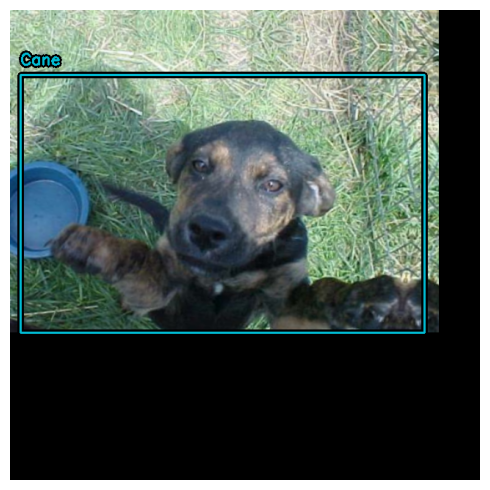

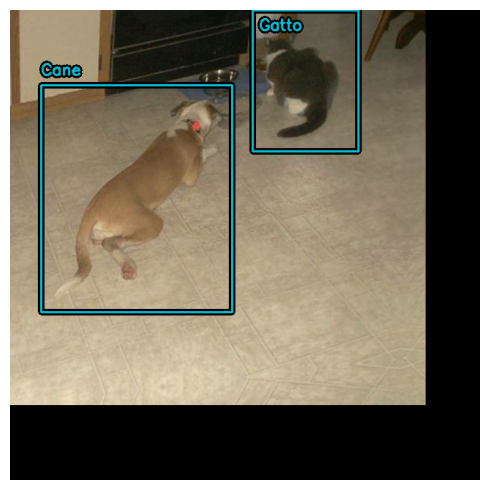

In [19]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(2)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

## Check Dataset

In [20]:
# def dict_to_tuple(inputs):
#     return inputs["images"], keras_cv.bounding_box.to_dense(
#         inputs["bounding_boxes"], max_boxes=32
#     )

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

In [21]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    BACKBONE_NAME,  # We will use yolov8 small backbone with coco weights
    load_weights=True
)
backbone.trainable = BACKBONE_TRAINABLE

/home/maog77/.virtualenvs/TF_GPU/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/maog77/.virtualenvs/TF_GPU/lib/python3.10/site-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [22]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    #fpn_depth=1
)

## Compile the Model

In [23]:
print(path_save_models + MODEL_NAME)


../../Yolo8_Dataset/Animali/models/model-m-bbfreez-Animali


In [24]:
if os.path.isfile(path_save_models + MODEL_NAME + ".h5"):
    yolo.load_weights(path_save_models + MODEL_NAME + ".h5")

In [25]:
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)
#yolo.summary()

In [26]:
trainable_params = 0 
for layer in yolo.trainable_weights:
    trainable_params += layer.numpy().size
print(F"Trainable Params: {trainable_params}")

Trainable Params: 14001606


In [27]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(        
            bounding_box_format="xyxy",
            evaluate_freq=1 #1e9,
        )

        self.save_path = save_path
        self.best_map = bestResult #-1
        #self.best_map = 999

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        tot = self.data.cardinality().numpy()
        i=0
        for batch in self.data:
            i+=1
            print(F"\rCalculate Accuracy Batch {i}/{tot}", end="")
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            y_pred_ragged = bounding_box.to_ragged(y_pred)
            self.metrics.update_state(y_true, y_pred_ragged)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = logs["MaP"]
        #print(F"Calculated MaP: {current_map}")
        #current_map = logs["val_loss"]
        if current_map > self.best_map:
            self.best_map = current_map
            #Save best MaP ti file
            tosave = {"BestMap": self.best_map}
            with open(F'{self.save_path}.pkl', 'wb') as f:
                pickle.dump(tosave, f)
            now = datetime.datetime.now()
            #self.model.save(self.save_path + "-test"+ now.strftime("-%m%d%Y-%H%M%S") + ".h5")
            self.model.save(self.save_path + ".h5")

        return logs


In [28]:
#yolo.save("model_3ep.h5")

In [29]:
print(path_log_tensorboard)

../../Yolo8_Dataset/logs/fit/


In [30]:
# path per i log di TensorBoard
#log_dir = "logs/fit/" + MODEL_NAME + F"-Epoch{INITIAL_EPOCH}-{EPOCH}"# + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = path_log_tensorboard + MODEL_NAME
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)

## Train the Model

In [31]:
print(path_save_models + MODEL_NAME)

../../Yolo8_Dataset/Animali/models/model-m-bbfreez-Animali


In [32]:
# definizione di due callback per migliorare l'addestramento
early_stopping = keras.callbacks.EarlyStopping(monitor="MaP", patience=20, mode='max', verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="MaP", patience=5, factor=0.66, mode='max', min_lr=1.0000e-5, cooldown=5)

#coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
#    val_ds.take(2), bounding_box_format="xyxy"
#)

history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, path_save_models + MODEL_NAME), tensorboard_callback, reduce_lr, early_stopping]#, early_stopping]
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, MODEL_NAME), tensorboard_callback, reduce_lr]#, early_stopping]
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, MODEL_NAME), reduce_lr]#, early_stopping]
    #callbacks=[coco_metrics_callback, tensorboard_callback, reduce_lr]#, early_stopping]
    #callbacks=[coco_metrics_callback, reduce_lr]#, early_stopping]
)

Epoch 57/100


2024-02-28 12:54:12.733854: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-28 12:54:12.821999: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-28 12:54:13.338234: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-28 12:54:27.790875: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-02-28 12:54:27.921917: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance 

Calculate Accuracy Batch 2/2=========] - ETA: 0s - loss: 1.7587 - box_loss: 1.2992 - class_loss: 0.4595

/home/maog77/.virtualenvs/TF_GPU/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 62s 874ms/step - loss: 1.7587 - box_loss: 1.2992 - class_loss: 0.4595 - val_loss: 1.9075 - val_box_loss: 1.4439 - val_class_loss: 0.4636 - MaP: 0.5822 - MaP@[IoU=50]: 0.9345 - MaP@[IoU=75]: 0.7541 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.5822 - Recall@[max_detections=1]: 0.6167 - Recall@[max_detections=10]: 0.6222 - Recall@[max_detections=100]: 0.6222 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.6222 - lr: 0.0010
Epoch 58/100
27/27 [==============================] - 14s 475ms/step - loss: 1.6192 - box_loss: 1.1840 - class_loss: 0.4352 - val_loss: 1.8207 - val_box_loss: 1.3668 - val_class_loss: 0.4539 - MaP: 0.5081 - MaP@[IoU=50]: 0.9312 - MaP@[IoU=75]: 0.5504 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.5081 - Recall@[max_detections=1]: 0.5813 - Recall@[max_detections=10]: 0.5813 - Recall@[max_detections=100]: 0.58

2024-02-28 12:55:32.960563: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 49152128 bytes after encountering the first element of size 49152128 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


27/27 [==============================] - 15s 504ms/step - loss: 1.5896 - box_loss: 1.1906 - class_loss: 0.3991 - val_loss: 1.7401 - val_box_loss: 1.2981 - val_class_loss: 0.4420 - MaP: 0.5892 - MaP@[IoU=50]: 0.8944 - MaP@[IoU=75]: 0.7991 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.5892 - Recall@[max_detections=1]: 0.6389 - Recall@[max_detections=10]: 0.6389 - Recall@[max_detections=100]: 0.6389 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.6389 - lr: 0.0010
Epoch 61/100
27/27 [==============================] - 14s 484ms/step - loss: 1.5895 - box_loss: 1.1741 - class_loss: 0.4154 - val_loss: 1.8740 - val_box_loss: 1.4283 - val_class_loss: 0.4457 - MaP: 0.5451 - MaP@[IoU=50]: 0.9092 - MaP@[IoU=75]: 0.5408 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.5451 - Recall@[max_detections=1]: 0.6075 - Recall@[max_detections=10]: 0.6075 - Recall@[max_detections=100]: 0.60

2024-02-28 12:59:18.476127: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 49152128 bytes after encountering the first element of size 49152128 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


27/27 [==============================] - 15s 489ms/step - loss: 1.3222 - box_loss: 1.0021 - class_loss: 0.3200 - val_loss: 1.6348 - val_box_loss: 1.2146 - val_class_loss: 0.4202 - MaP: 0.6735 - MaP@[IoU=50]: 1.0000 - MaP@[IoU=75]: 0.7960 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.4000 - MaP@[area=large]: 0.7058 - Recall@[max_detections=1]: 0.7093 - Recall@[max_detections=10]: 0.7093 - Recall@[max_detections=100]: 0.7093 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.4000 - Recall@[area=large]: 0.7367 - lr: 6.6000e-04
Epoch 76/100
27/27 [==============================] - 14s 498ms/step - loss: 1.2962 - box_loss: 0.9816 - class_loss: 0.3146 - val_loss: 1.6174 - val_box_loss: 1.2378 - val_class_loss: 0.3796 - MaP: 0.6479 - MaP@[IoU=50]: 0.9859 - MaP@[IoU=75]: 0.7197 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.4000 - MaP@[area=large]: 0.6652 - Recall@[max_detections=1]: 0.6800 - Recall@[max_detections=10]: 0.6800 - Recall@[max_detections=100]: 0.6800 - Rec

In [ ]:
#yolo.save(MODEL_NAME + "_end.h5")

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['box_loss'], label='box_loss')
plt.plot(history.history['class_loss'], label='class_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_box_loss'], label='val_box_loss')
plt.plot(history.history['val_class_loss'], label='val_class_loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
plt.plot(history.history['MaP'], label='MaP')
plt.plot(history.history['MaP@[IoU=50]'], label='MaP IoU=50')
plt.plot(history.history['MaP@[IoU=75]'], label='MaP IoU=75')
plt.plot(history.history['MaP@[area=small]'], label='MaP area small')
plt.plot(history.history['MaP@[area=medium]'], label='MaP area medium')
plt.plot(history.history['MaP@[area=large]'], label='MaP area large')
plt.legend(loc="upper right")
plt.show()

In [ ]:
plt.plot(history.history['Recall@[max_detections=1]'], label='Recall max_detections 1')
plt.plot(history.history['Recall@[max_detections=10]'], label='Recall max_detections 10')
plt.plot(history.history['Recall@[max_detections=100]'], label='Recall max_detections 100')
plt.plot(history.history['Recall@[area=small]'], label='Recall area small')
plt.plot(history.history['Recall@[area=medium]'], label='Recall area medium')
plt.plot(history.history['Recall@[area=large]'], label='Recall area large')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# import pandas
# now = datetime.datetime.now()
# pandas.DataFrame.from_dict(history.history).to_csv(HISTORY_NAME + now.strftime("-%m%d%Y-%H%M%S") + '.csv',index=False)

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")